Loaded pretrained weights for efficientnet-b2


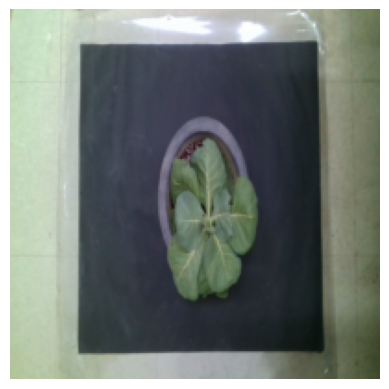

Predicted Class: ca2_leaf
Probability: 1.0000


In [6]:
import torch
import torchvision.transforms as transforms
import json
import os
from efficientnet_pytorch import EfficientNet
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

# 모델 정의 (학습 코드와 동일)
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        self.image_model = EfficientNet.from_pretrained('efficientnet-b2')
        
        # 텍스트 인코더 정의 (예: 간단한 MLP)
        self.text_encoder = nn.Sequential(
            nn.Linear(6, 128),  # 텍스트 입력 차원을 6으로 변경
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Global Average Pooling Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # 이미지와 텍스트 임베딩을 결합하여 분류
        self.classifier = nn.Sequential(
            nn.Linear(64 + self.image_model._fc.in_features, 256),  # EfficientNet의 마지막 FC layer 크기
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, text):
        # EfficientNet을 통해 이미지 특징 추출
        image_features = self.image_model.extract_features(image)
        image_features = self.global_avg_pool(image_features)  # Global Average Pooling
        image_features = image_features.view(image_features.size(0), -1)  # 2차원 텐서로 변환
        
        # 텍스트 인코딩
        text_features = self.text_encoder(text)

        # 이미지와 텍스트 특징을 결합
        combined_features = torch.cat((image_features, text_features), dim=1)

        # 최종 분류
        outputs = self.classifier(combined_features)
        return outputs
to_classes = 2
ca_classes = 2

# 하이퍼파라미터 설정
num_classes = to_classes # 클래스 수 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 학습된 가중치 로드
model = MultimodalModel(num_classes=num_classes)
model.load_state_dict(torch.load('weights/2Cycle_CA.pth'))
model.to(device)
model.eval()

# 이미지와 텍스트 전처리 정의
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # 배치 차원을 추가
    return image

def preprocess_text(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        text_features = json.load(f)
    
    measurements = text_features['measurement'][0]
    measurement_values = [
        measurements['fruit_length'],
        measurements['fruit_width'],
        measurements['leaf_length'],
        measurements['leaf_width'],
        measurements['joint_length'],
        measurements['central_length']
    ]
    
    measurement_values = [0.0 if v == '-' else float(v) for v in measurement_values]
    text_tensor = torch.tensor(measurement_values, dtype=torch.float32).unsqueeze(0)  # 배치 차원을 추가
    return text_tensor

# 추론 함수 (확률 계산 포함)
def predict(image_path, json_path):
    image = preprocess_image(image_path).to(device)
    text = preprocess_text(json_path).to(device)
    
    with torch.no_grad():
        outputs = model(image, text)
        probabilities = torch.softmax(outputs, dim=1)  # 소프트맥스 함수로 확률 계산
        _, preds = torch.max(outputs, 1)
    
    return preds.item(), probabilities.squeeze()

# 테스트용 이미지와 JSON 파일 경로
test_image_path = 'infe_images/plant/ca2_1.jpg'  # 실제 이미지 경로로 변경
test_json_path = 'TO.json'  # 실제 JSON 경로로 변경

# 예측 수행
to_class_names = ['to1_fruit', 'to2_fruit']
ca_class_names = ['ca1_leaf', 'ca2_leaf']


predicted_class_idx, probabilities = predict(test_image_path, test_json_path)
class_names = ca_class_names  # 클래스 이름 정의
predicted_class_name = class_names[predicted_class_idx]
predicted_probability = probabilities[predicted_class_idx].item()


# 이미지 변환 후 시각화
img = preprocess_image(test_image_path).squeeze().permute(1, 2, 0)  # 배치 및 채널 순서 수정
img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # 정규화 복원
img = img.clip(0, 1)  # 이미지 범위 [0, 1]로 제한

plt.imshow(img)
plt.axis('off')  # 축 제거
plt.show()

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {predicted_probability:.4f}")


Best Test Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Test Metrics for each epoch:
Epoch | Accuracy | Precision | Recall | F1 Score
--------------------------------------------------
    1 | 1.0000 | 1.0000 | 1.0000 | 1.0000


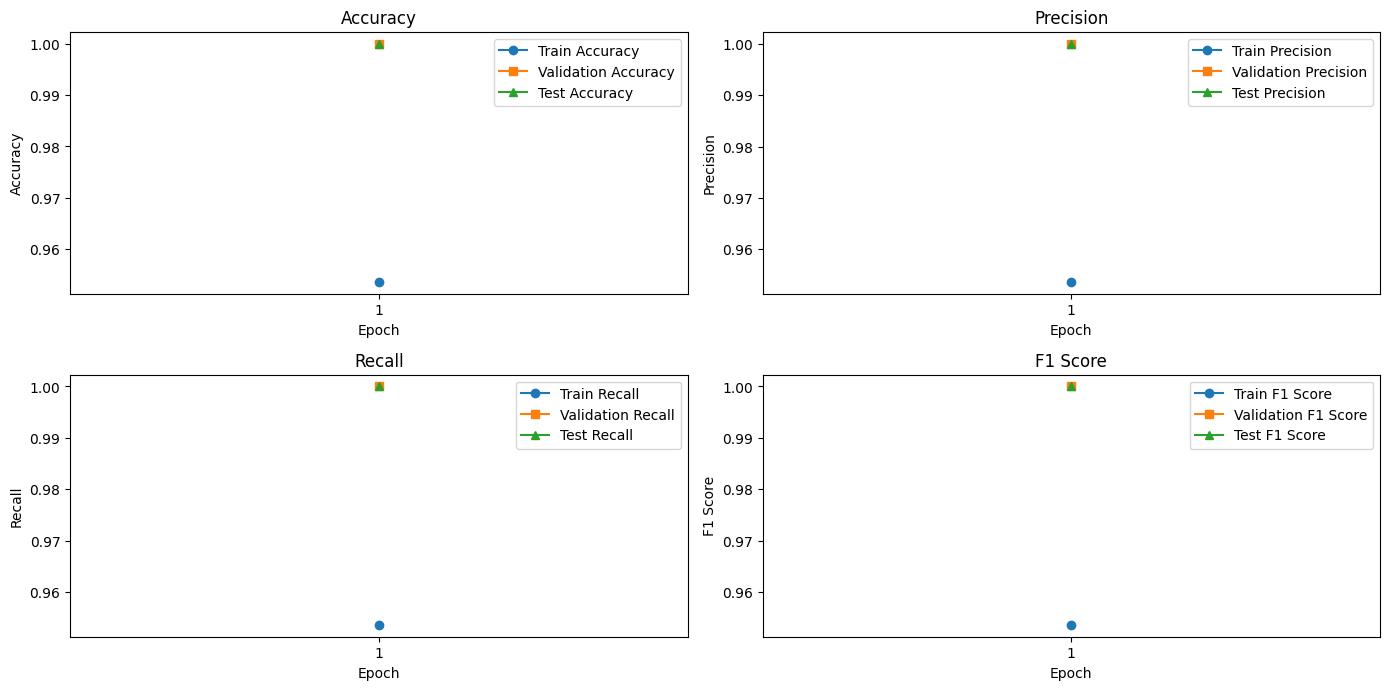

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# metrics.npy 파일에서 데이터 로드
metrics = np.load('metrics/2Cycle_CA.npy', allow_pickle=True).item()

# 각 메트릭 데이터 추출
train_acc_list = metrics['train_acc']
train_prec_list = metrics['train_prec']
train_rec_list = metrics['train_rec']
train_f1_list = metrics['train_f1']

val_acc_list = metrics['val_acc']
val_prec_list = metrics['val_prec']
val_rec_list = metrics['val_rec']
val_f1_list = metrics['val_f1']

test_acc_list = metrics['test_acc']
test_prec_list = metrics['test_prec']
test_rec_list = metrics['test_rec']
test_f1_list = metrics['test_f1']

# 가장 좋은 지표 찾기
best_test_acc_index = np.argmax(test_acc_list)
best_test_acc = val_acc_list[best_test_acc_index]
best_test_prec = val_prec_list[best_test_acc_index]
best_test_rec = val_rec_list[best_test_acc_index]
best_test_f1 = val_f1_list[best_test_acc_index]

# 예시로 가장 좋은 지표 출력
print("Best Test Metrics:")
print("Accuracy:", best_test_acc)
print("Precision:", best_test_prec)
print("Recall:", best_test_rec)
print("F1 Score:", best_test_f1)

# Epoch 수
epochs = len(train_acc_list)

# 각 epoch별 테스트 메트릭 출력
print("Test Metrics for each epoch:")
print("Epoch | Accuracy | Precision | Recall | F1 Score")
print("-" * 50)
for epoch in range(epochs):
    print(f"{epoch+1:5d} | {test_acc_list[epoch]:.4f} | {test_prec_list[epoch]:.4f} | {test_rec_list[epoch]:.4f} | {test_f1_list[epoch]:.4f}")

# Plotting train/validation/test metrics
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy', marker='s')
plt.plot(range(1, epochs + 1), test_acc_list, label='Test Accuracy', marker='^')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, epochs + 1))
plt.legend()

# Precision
plt.subplot(3, 2, 2)
plt.plot(range(1, epochs + 1), train_prec_list, label='Train Precision', marker='o')
plt.plot(range(1, epochs + 1), val_prec_list, label='Validation Precision', marker='s')
plt.plot(range(1, epochs + 1), test_prec_list, label='Test Precision', marker='^')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(range(1, epochs + 1))
plt.legend()

# Recall
plt.subplot(3, 2, 3)
plt.plot(range(1, epochs + 1), train_rec_list, label='Train Recall', marker='o')
plt.plot(range(1, epochs + 1), val_rec_list, label='Validation Recall', marker='s')
plt.plot(range(1, epochs + 1), test_rec_list, label='Test Recall', marker='^')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(range(1, epochs + 1))
plt.legend()

# F1 Score
plt.subplot(3, 2, 4)
plt.plot(range(1, epochs + 1), train_f1_list, label='Train F1 Score', marker='o')
plt.plot(range(1, epochs + 1), val_f1_list, label='Validation F1 Score', marker='s')
plt.plot(range(1, epochs + 1), test_f1_list, label='Test F1 Score', marker='^')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()
